In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import cufflinks as cf

In [2]:
df = pd.read_csv("arduino_trends.csv")

Epoch 1/50
40/40 - 1s - loss: 0.1029 - 853ms/epoch - 21ms/step
Epoch 2/50
40/40 - 0s - loss: 0.0705 - 33ms/epoch - 837us/step
Epoch 3/50
40/40 - 0s - loss: 0.0610 - 32ms/epoch - 796us/step
Epoch 4/50
40/40 - 0s - loss: 0.0565 - 28ms/epoch - 695us/step
Epoch 5/50
40/40 - 0s - loss: 0.0549 - 44ms/epoch - 1ms/step
Epoch 6/50
40/40 - 0s - loss: 0.0528 - 28ms/epoch - 706us/step
Epoch 7/50
40/40 - 0s - loss: 0.0509 - 27ms/epoch - 687us/step
Epoch 8/50
40/40 - 0s - loss: 0.0503 - 27ms/epoch - 679us/step
Epoch 9/50
40/40 - 0s - loss: 0.0493 - 39ms/epoch - 975us/step
Epoch 10/50
40/40 - 0s - loss: 0.0481 - 28ms/epoch - 702us/step
Epoch 11/50
40/40 - 0s - loss: 0.0474 - 27ms/epoch - 687us/step
Epoch 12/50
40/40 - 0s - loss: 0.0466 - 27ms/epoch - 673us/step
Epoch 13/50
40/40 - 0s - loss: 0.0467 - 28ms/epoch - 693us/step
Epoch 14/50
40/40 - 0s - loss: 0.0459 - 28ms/epoch - 693us/step
Epoch 15/50
40/40 - 0s - loss: 0.0469 - 27ms/epoch - 671us/step
Epoch 16/50
40/40 - 0s - loss: 0.0451 - 27ms/epoch 

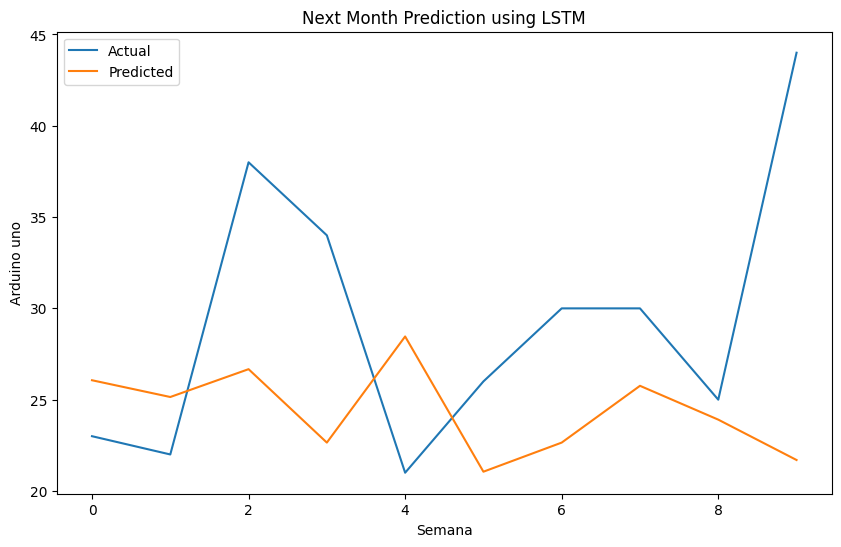

In [3]:
# Seleccionar la columna objetivo
target_column = 'Arduino uno'
df_target = df[['Semana', target_column]]

# Convertir la columna 'Semana' a tipo fecha
df_target['Semana'] = pd.to_datetime(df_target['Semana'])

# Establecer 'Semana' como índice
df_target.set_index('Semana', inplace=True)

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
df_target_scaled = scaler.fit_transform(df_target)

# Preparar los datos para el modelo LSTM
def create_dataset(dataset, time_steps=1):
    X, y = [], []
    for i in range(len(dataset)-time_steps):
        a = dataset[i:(i+time_steps), 0]
        X.append(a)
        y.append(dataset[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 1
X, y = create_dataset(df_target_scaled, time_steps)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape para LSTM (número de muestras, número de time steps, número de características)
X_train = np.reshape(X_train, (X_train.shape[0], time_steps, 1))
X_test = np.reshape(X_test, (X_test.shape[0], time_steps, 1))

# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenar el modelo
epochs = 50
batch_size = 1
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=2)

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Invertir la escala para obtener valores reales
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Calcular el error cuadrático medio en la escala original
mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f'Mean Squared Error: {mse}')

# Visualizar las predicciones
plt.figure(figsize=(10, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title('Next Month Prediction using LSTM')
plt.xlabel('Semana')
plt.ylabel(target_column)
plt.legend()
plt.show()

In [4]:
df_line = df[["Arduino uno", "Placa de pruebas", "Protoboard","Arduino nano", "Semana"]]
df_line.head(5) 

,Arduino uno,Placa de pruebas,Protoboard,Arduino nano,Semana
0,36,39,30,17,2023-01-01
1,17,57,43,19,2023-01-08
2,35,66,49,19,2023-01-15
3,33,70,73,0,2023-01-22
4,21,37,34,8,2023-01-29


In [5]:

# Configurar Cufflinks con tu clave de acceso a Plotly
cf.go_offline()

# Crear un DataFrame para las predicciones
df_pred = pd.DataFrame(index=df_target.index[-len(y_test):])
df_pred['Actual'] = y_test_inv
df_pred['Predicted'] = np.nan
df_pred['Predicted'][-len(y_pred_inv):] = y_pred_inv.flatten()

# Combinar los DataFrames originales y de predicciones sin incluir 'Semana' nuevamente
df_combined = pd.concat([df_target['Arduino uno'], df_pred['Actual'], df_pred['Predicted']], axis=1)

# Crear un gráfico interactivo utilizando iplot
fig = df_combined.iplot(
    kind='line',
    xTitle='Semana',
    yTitle='Frecuencia',
    title='Frecuencia de búsquedas de Arduino uno con predicciones',
    asFigure=True
)

# Configurar el modo de información al pasar el ratón (hovermode)
fig.update_layout(hovermode='x')

# Mostrar el gráfico
fig.show()